In [1]:
# Imports
import torch
import torchvision 
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image
import spectral as spec

from dataGen import Patches
from ResNet.ResNet import ResNet as CNN

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

1

In [10]:
# Hyperparameters

in_channels = 3
classes = ["background", "leaf", "diseased"]
num_classes = len(classes)
rgb_bands = [0, 1, 2]
batch_size = 32
img_size = 100
res_dir = "F:\\Lukas\\Project\\노균병\\code\\result\\23_3_15 ResNet2D_rgb_25_aug\\"
model_dir = res_dir + "ResNet_rgb_25_노균병_best.pt"
train_dir = res_dir + "train.csv"
val_dir = res_dir + "val.csv"

In [11]:
# Custom image dataset

class Img(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, :])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [12]:
def tensorToImg(tensor, img_size):
    img = torch.zeros(img_size, img_size, len(rgb_bands))
    for i, b in enumerate(rgb_bands):
        img[:,:,b] = tensor[i]
    return img

In [13]:
def displayImgs(imgs, labels, img_size, n=batch_size, save=False):
    fig = plt.figure(figsize=(20,11))
    for i, img in enumerate(imgs[:n]):
        img = tensorToImg(img, img_size)
        fig.add_subplot(4, 8, i + 1).title.set_text(classes[labels[i]])
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

In [14]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])

In [15]:
def getDataset(patch, dc, train_frac = .7, data_type='hdr'):
    patch_ds = patch.generateAndSplitDataset(
        dataset_composition = [[classes[i], dc[i]] for i in range(len(classes))],
        data_type = data_type,
        train_frac = train_frac)
    for p in patch_ds:
        for i, c in enumerate(classes):
             p.loc[(p['class'] == c), 'class'] = i

        print(p.describe())
    
    return patch_ds

In [16]:
patch_ds = (pd.read_csv(train_dir),
            pd.read_csv(val_dir))
patch_ds_aug = (pd.read_csv(res_dir + "aug_train.csv"), 
              pd.read_csv(res_dir + "aug_val.csv"))

In [17]:
# patch_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES")
# patch_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES")

In [18]:
# patch_14_ds = getDataset(patch_14, [48, 450, 450], train_frac = .3)
# patch_21_ds = getDataset(patch_21, [61, 500, 500], train_frac = .3)

In [19]:
def extractDs(ds, d):
    ds = (patch_ds[0][patch_ds[0]["path"].str.contains(d)],
          patch_ds[1][patch_ds[1]["path"].str.contains(d)])
    
    return ds

In [20]:
# patch_25_ds = extractDs(patch_ds, "gys_22_10_28_rgb")

In [21]:
def transformDs(patch, n=1):
    ds = []
    for i in range(n):
        ds.append(Img(img_df=patch, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((img_size, img_size)),
                        transforms.RandomRotation(degrees=(int(360/(n + 1)) * (i + 1))),
                        transforms.ConvertImageDtype(torch.float)])
                     )
                 )
        
    return ds

In [39]:
def augmentPatch(patch, n):
    dataset = [[],[]]
    for i, p in enumerate(patch):
        for i2 in range(len(n)):
            p_filter = p.loc[p['class'] == i2]
            dataset_c = transformDs(p_filter, n[i2])
            for dc in dataset_c:
                dataset[i].append(dc)
                
    return dataset

In [40]:
def countDs(ds):
    c = {c:0 for c in classes}
    for d in ds:
        c[classes[d[1]]] += 1
    return c

In [41]:
train_patch = patch_ds[0]
val_patch = patch_ds[1]

In [42]:
patch_ds_aug_25 = augmentPatch(patch_ds_aug, [1, 1, 8])

In [44]:
train_dataset_ori = Img(img_df=train_patch, transform=img_transform)
val_dataset_ori = Img(img_df=val_patch, transform=img_transform)

train_dataset = ConcatDataset([train_dataset_ori] + patch_ds_aug_25[0])
val_dataset = ConcatDataset([val_dataset_ori] + patch_ds_aug_25[1])

print(f"The num of training dataset is {len(train_dataset)} and num of validation dataset is {len(val_dataset)}")
print(countDs(train_dataset), countDs(val_dataset))

The num of training dataset is 1917 and num of validation dataset is 819
{'background': 630, 'leaf': 630, 'diseased': 657} {'background': 270, 'leaf': 270, 'diseased': 279}


In [45]:
train_loader_ori = DataLoader(dataset=train_dataset_ori, batch_size=batch_size, shuffle=True)
test_loader_ori = DataLoader(dataset=val_dataset_ori, batch_size=batch_size, shuffle=True)
ds_all_ori = DataLoader(dataset=ConcatDataset([train_dataset_ori, val_dataset_ori]), 
                        batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
ds_all = DataLoader(dataset=ConcatDataset([train_dataset, val_dataset]), 
           batch_size=batch_size, shuffle=True)

In [46]:
next(iter(train_loader))[0].shape   

torch.Size([32, 3, 100, 100])

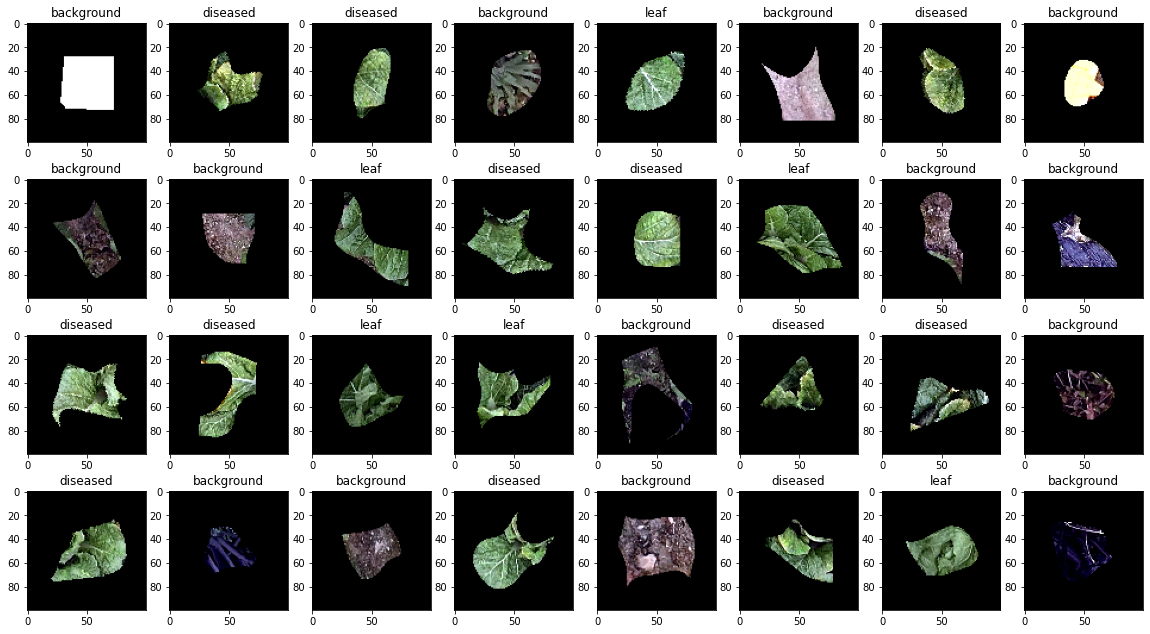

In [47]:
# Check the images
for train_batch in train_loader:
    displayImgs(train_batch[0], train_batch[1], img_size, save=False)
    break

In [48]:
# Initialize network

model = CNN(in_channels=in_channels, num_classes=len(classes)).to(device)
print("Num of param:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of param: 22266115


In [49]:
# Load weights
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [50]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (downsample): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=43264, out_features=512, bias=True

In [51]:
# Predict 
def predictDataset(loader, model, display=False):
    actual = np.array([])
    prediction = np.array([])
    display_count = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
            if display and display_count == 0:
                displayImgs(x, prediction.astype(int), img_size, save=True)
                display_count += 1
    model.train()
    
    return actual, prediction

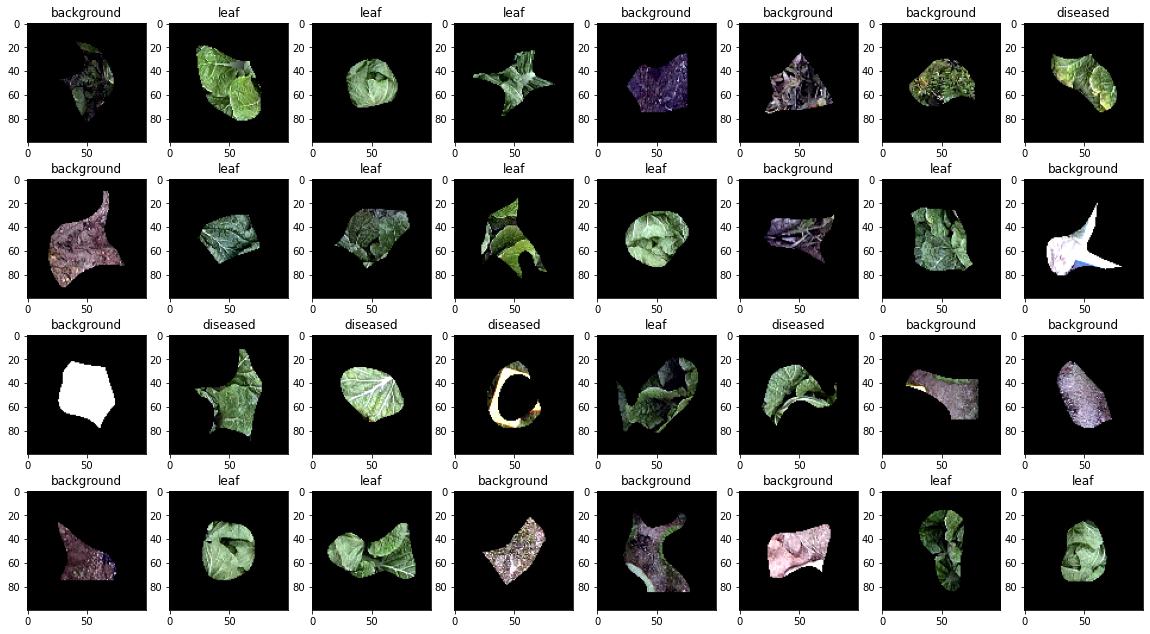

In [52]:
actual_test_ori, prediction_test_ori = predictDataset(test_loader_ori, model, display=True)
actual_all_ori, prediction_all_ori = predictDataset(ds_all_ori, model)

actual_test, prediction_test = predictDataset(test_loader, model)
actual_all, prediction_all = predictDataset(ds_all, model)

In [53]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

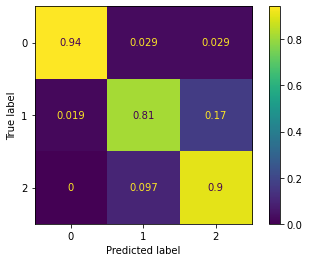

In [55]:
drawConfusionMatrix(actual_test_ori, prediction_test_ori, normalize=True)

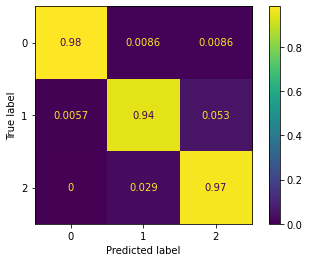

In [56]:
drawConfusionMatrix(actual_all_ori, prediction_all_ori, normalize=True)

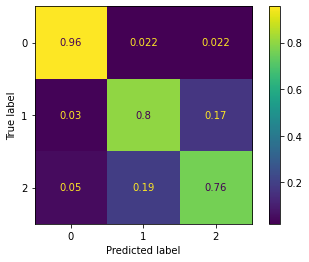

In [57]:
drawConfusionMatrix(actual_test, prediction_test, normalize=True)

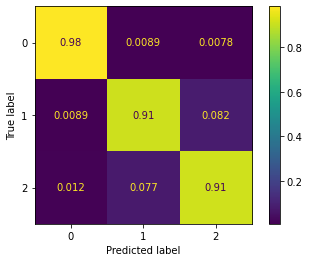

In [58]:
drawConfusionMatrix(actual_all, prediction_all, normalize=True)